In [1]:
#!pip3 install torch scikit-learn numpy matplotlib seaborn

In [2]:
!gdown 1_BTN5UIec4casuWmftPBwatxVEJp0qLx

Downloading...
From: https://drive.google.com/uc?id=1_BTN5UIec4casuWmftPBwatxVEJp0qLx
To: /content/arcos_gerados.txt
100% 3.28M/3.28M [00:00<00:00, 50.1MB/s]


In [3]:
#imports básicos
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Testa se tem como usar CUDA (GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lê o dataset
data = []
with open('arcos_gerados.txt', 'r') as file:
    for line in file:
        input_str, target_str = line.strip().split(',')
        data.append((input_str, target_str))

# Divide as strings em entrada e saída, separando-as em listas
X = [list(map(int, input_str)) for input_str, _ in data]
y = [list(map(int, target_str)) for _, target_str in data]

# Transforma as listas em tensores
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [5]:
# A rede neural
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size) # Rede neural com 4 camadas, 2 ocultas com 64 neurônios
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        # x = torch.sigmoid(self.fc4(x))  # Curva sigmoide ajuda a "truncar" os valores em 0 e 1
        return x

# O tamanho da camada de entrada e de saída pode ser extraido dos próprios
# datasets, para trazer maior flexibilidade ao programa
input_size = X_tensor.shape[1]
output_size = y_tensor.shape[1]

# Função de treinamento
def train_model(train_loader, model, criterion, optimizer, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Se a GPU estiver disponível, move os dados para a RAM dela
            optimizer.zero_grad() # Zera os gradientes
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch) # Calcula o erro
            loss.backward() # Computa os gradientes
            optimizer.step()
    return model

# Função de avaliação
def evaluate_model(test_loader, model):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Se a GPU estiver disponível, move os dados para a RAM dela
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()  # Trunca os valores da camada de saída categoricamente (0 ou 1)
            # Puxa os dados de volta pra CPU para calcular as métricas propostas
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    # Converte as listas em np.array (parar calcular as métricas)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision = precision_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    recall = recall_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    f1 = f1_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    conf_matrix = confusion_matrix(y_true.flatten(), y_pred.flatten())
    roc_auc = roc_auc_score(y_true.flatten(), y_pred.flatten(), average='weighted')
    logloss = log_loss(y_true.flatten(), y_pred.flatten())

    return accuracy, precision, recall, f1, conf_matrix, roc_auc, logloss

# K-fold CV com 10 folds
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=1)
fold_results = []
last_test_dataset = None

for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    print(f'Fold {fold+1}/{k}')

    # Gera os loaders para cada fold
    train_dataset = Subset(TensorDataset(X_tensor, y_tensor), train_idx)
    test_dataset = Subset(TensorDataset(X_tensor, y_tensor), test_idx)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # O último dataset de testes é guardado pra pegar um sample depois
    if fold == k - 1:
        last_test_dataset = test_dataset
        # last_conf_matrix = results[4]

    # Inicializa o modelo (dentro da GPU se der)
    model = NeuralNet(input_size, output_size).to(device)
    criterion = nn.BCELoss()  # BCE é um critério de erro bem legal de usar em dados binários: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Chama o treino
    model = train_model(train_loader, model, criterion, optimizer)

    # Salva o modelo (para execução posterior)
    torch.save(model.state_dict(), f'model_fold_{fold+1}.pth')
    torch.save(optimizer.state_dict(), f'optimizer_fold_{fold+1}.pth')

    # Faz a avaliação do fold atual
    results = evaluate_model(test_loader, model)
    fold_results.append(results)

    # O último dataset de testes é guardado pra pegar um sample depois
    if fold == k - 1:
        # last_test_dataset = test_dataset
        last_conf_matrix = results[4]

# A média de todos os folds é calculada para ver se o modelo aprende consistentemente com diferentes dados de entrada
avg_accuracy = np.mean([result[0] for result in fold_results])
avg_precision = np.mean([result[1] for result in fold_results])
avg_recall = np.mean([result[2] for result in fold_results])
avg_f1 = np.mean([result[3] for result in fold_results])
avg_roc_auc = np.mean([result[5] for result in fold_results])
avg_logloss = np.mean([result[6] for result in fold_results])

print("--------- MÉTRICAS ------------")

print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')
print(f'Average ROC-AUC: {avg_roc_auc}')
print(f'Average Log Loss: {avg_logloss}')

print("---------- TESTE -------------")


# Recarrega o modelo utilizado no último fold
loaded_model = NeuralNet(input_size, output_size).to(device)
loaded_model.load_state_dict(torch.load(f'model_fold_{k}.pth'))
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=0.001)
loaded_optimizer.load_state_dict(torch.load(f'optimizer_fold_{k}.pth'))

# Coloca o modelo carregado em modo "eval" (inferência):
loaded_model.eval()

# Adquire um "sample" da simulção, será impresso uma entrada e uma saída só pra enxergar o modelo funcionando
def get_sample_prediction(input_str):
    # Faz reconversão do tensor para string
    input_list = list(map(int, input_str))
    input_tensor = torch.tensor(input_list, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Prevê a saída
    with torch.no_grad():
        output_tensor = loaded_model(input_tensor)
        predicted = (output_tensor > 0.5).float()  # Convert probabilities to binary outputs

    # tensor para string (volta ao formato anterior)
    output_list = predicted.squeeze().cpu().numpy().astype(int).tolist()
    output_str = ''.join(map(str, output_list))
    return output_str

# Pega o últmo dataset utilizado anteriormente
sample_input_tensor, _ = last_test_dataset[0]
sample_input_str = ''.join(map(str, sample_input_tensor.int().tolist()))

# Teste
predicted_output = get_sample_prediction(sample_input_str)
print(f'Entrada: {sample_input_str}')
print(f'Saída: {predicted_output}')

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10
--------- MÉTRICAS ------------
Average Accuracy: 0.9247274357634409
Average Precision: 0.925355864746934
Average Recall: 0.9247274357634409
Average F1 Score: 0.924698085661612
Average ROC-AUC: 0.924738274653435
Average Log Loss: 1.2000243207401409
---------- TESTE -------------
Entrada: 0000000000001110
Saída: 00001101000011000000000000000001


<ipython-input-5-e4e6c477554b>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f'model_fold_{k}.pth'))
<ipython-input-5-e4e6c47755

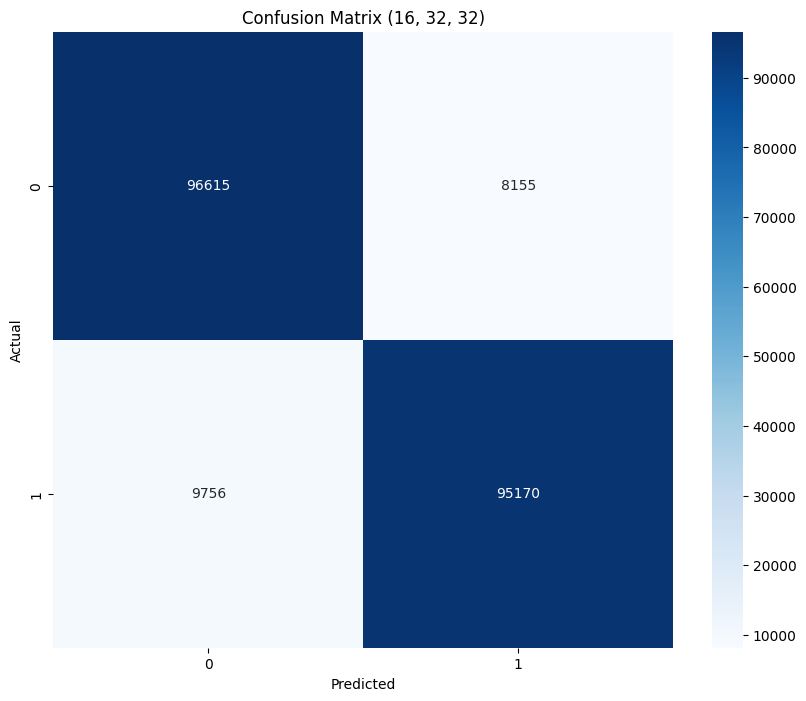

In [8]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (16, 32, 32)')
    plt.show()

def plot_accuracy_over_folds(accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Folds (16, 32, 32)')
    plt.grid(True)
    plt.show()

# Plot the confusion matrix for the last fold
plot_confusion_matrix(last_conf_matrix)

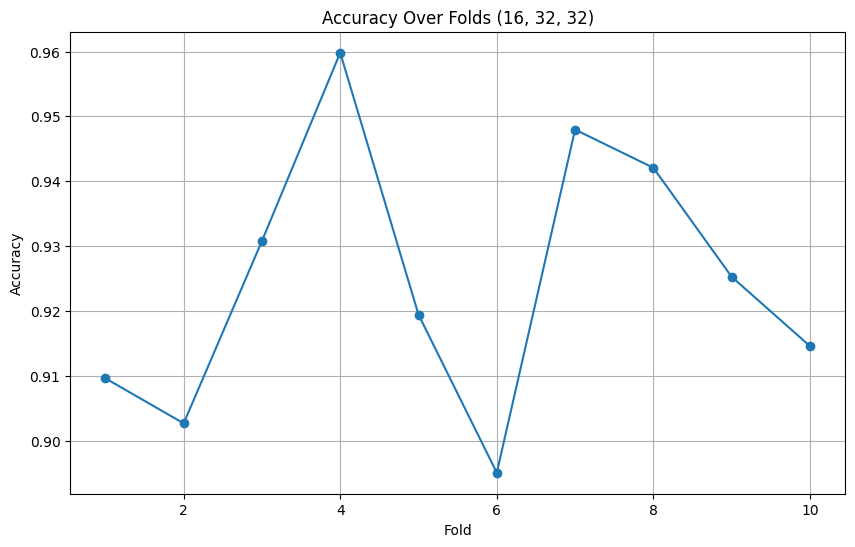

In [9]:
plot_accuracy_over_folds([result[0] for result in fold_results])